In [1]:
%run func_def.ipynb

**imports loaded.

> Pre-Processing func:
    get_striking_efficiency(name, date)
    get_height(item)
    get_weight(item)
    get_reach(item)
    get_std_reach(item, height, reach_list, height_list)
    get_age(item)
    get_std_age(item, age_list)
    get_win_prob(name, date, df)
    get_win_streak(name, date, df) #return count of recent wins
    get_lose_streak(name, date, df)
    get_fighter_stats(name, data )

> Feature Engineering func:
    get_stat(index, data, stat='height', fo='')
    get_swaped_row(index, data) # return fighter & opponent statistics swapped. 
    get_wins(combo, data)
    get_wins_ratio(combo, data)

> outlier_cleaning func:
    set_outlier_detection_model(X_columns, data)

> model_stats_pred_training func:
    set_lower_cases(string)
    set_train_test(X_columns, y_columns, data, test_size=0.3, valid_size=0.3)
    set_xgboost_reg(X_columns, y_columns, data, n=200, learning_rate=0.2, subsample=0.4, max_depth=5)
    set_predictions(model, data, X_columns, y_c

# <span style='color:green'> **[done]** </span>Loading pre-processed data

In [2]:
loc = '../data/'
file = 'data_pre_processed.csv'
df = pd.read_csv(loc+file)
df.tail(3)

,result,fighter,opponent,f_kd,o_kd,f_str,o_str,f_td,o_td,f_sub,o_sub,weight_class,method,type,round,time,date,f_win_perc,o_win_perc,f_str_efc,o_str_efc,f_win_strk,o_win_strk,f_lose_strk,o_lose_strk,f_wins,f_losses,f_draws,f_height,f_weight,f_reach,f_stance,f_age,f_slpm,f_str_acc,f_sapm,f_str_def,f_td_avg,f_td_acc,f_td_def,f_sub_avg,f_last_match,o_wins,o_losses,o_draws,o_height,o_weight,o_reach,o_stance,o_age,o_slpm,o_str_acc,o_sapm,o_str_def,o_td_avg,o_td_acc,o_td_def,o_sub_avg,o_last_match
6391,win,Muhammad Naimov,Jamie Mullarkey,1,0,28,39,0,3,0,0,Lightweight,KO/TKO,Punch,2,2:59,2023-06-03,0.0,0.57,0.00000,0.00651,0,2,0,0,9,2,0,175.26,69.75,177.80,Orthodox,29.0,3.48,0.40,5.53,0.44,0.00,0.00,0.50,0.0,06-03-2023,16,6,0,182.88,69.75,187.96,Orthodox,29.0,4.20,0.46,4.20,0.54,2.91,0.35,0.75,0.2,06-03-2023
6392,win,Elise Reed,Jinh Yu Frey,0,0,53,28,0,3,0,0,Women's Strawweight,U-DEC,Unanimous,3,5:00,2023-06-03,0.5,0.40,0.00758,0.00000,0,0,1,1,7,3,0,160.02,51.75,160.02,Orthodox,31.0,2.95,0.50,3.14,0.53,0.66,0.75,0.50,0.0,06-03-2023,11,9,0,160.02,51.75,165.10,Southpaw,38.0,2.95,0.42,4.11,0.52,1.02,0.37,0.89,0.3,06-03-2023
6393,win,Da'Mon Blackshear,Luan Lacerda,0,0,66,28,1,1,0,1,Bantamweight,KO/TKO,Punches,2,3:54,2023-06-03,0.0,0.00,0.00000,0.00000,0,0,1,1,13,5,1,177.80,60.75,182.88,Switch,29.0,3.57,0.43,3.83,0.51,1.16,0.23,0.54,0.8,06-03-2023,12,3,0,170.18,60.75,180.34,Orthodox,30.0,4.52,0.44,7.07,0.47,1.26,0.25,0.75,0.6,06-03-2023


# <span style='color:green'> **[done]** </span>Feature Y
1. get randome rows & swap stats between fighters  
2. change result to "lose"
** this way first fighter will not always be the winner

In [3]:
original_size = len(df)

for i in tqdm(range(0,original_size)): 
    if random.random() > 0.5:
        df.loc[i] = get_swaped_row(index=i, data=df)

print(df.result.value_counts())     

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6394/6394 [00:25<00:00, 250.63it/s]

win     3202
lose    3192
Name: result, dtype: int64


## Column's Legend:
****
* <span style='color:blue'> **SLpM** </span> - Significant Strikes Landed per Minute
* <span style='color:blue'> **Str. Acc.** </span> - Significant Striking Accuracy
* <span style='color:blue'> **SApM** </span> - Significant Strikes Absorbed per Minute
* <span style='color:blue'> **Str. Def.** </span> - Significant Strike Defence (the % of opponents strikes that did not land)
* <span style='color:blue'> **TD Avg.** </span> - Average Takedowns Landed per 15 minutes
* <span style='color:blue'> **TD Acc.** </span> - Takedown Accuracy
* <span style='color:blue'> **TD Def.** </span> - Takedown Defense (the % of opponents TD attempts that did not land)
* <span style='color:blue'> **Sub. Avg.** </span> - Average Submissions Attempted per 15 minutes
* <span style='color:blue'> **Str. Efc.** </span> - Striking effectivness = knowdowns/strikes

# <span style='color:green'> **[done]** </span> Feature Engineering = past fight's statistics:

In [4]:
for column in ['kd','str','td','sub']:
    df = df[(df['f_' + column] != '--')&(df['o_' + column] != '--')].reset_index(drop=True)
    df[column + '_dif'] = df['f_' + column].astype(int) - df['o_' + column].astype(int)
    df = df.drop(columns=['f_' + column, 'o_' + column])
    
df.head(3)

,result,fighter,opponent,weight_class,method,type,round,time,date,f_win_perc,o_win_perc,f_str_efc,o_str_efc,f_win_strk,o_win_strk,f_lose_strk,o_lose_strk,f_wins,f_losses,f_draws,f_height,f_weight,f_reach,f_stance,f_age,f_slpm,f_str_acc,f_sapm,f_str_def,f_td_avg,f_td_acc,f_td_def,f_sub_avg,f_last_match,o_wins,o_losses,o_draws,o_height,o_weight,o_reach,o_stance,o_age,o_slpm,o_str_acc,o_sapm,o_str_def,o_td_avg,o_td_acc,o_td_def,o_sub_avg,o_last_match,kd_dif,str_dif,td_dif,sub_dif
0,win,Max Holloway,Arnold Allen,Featherweight,U-DEC,Unanimous,5,5:00,2023-04-15,0.73,1.00,0.00269,0.00723,0,10,1,0,24,7,0,180.34,65.25,175.26,Orthodox,32.0,7.16,0.47,4.79,0.59,0.28,0.53,0.84,0.3,04-15-2023,19,2,0,172.72,65.25,177.80,Southpaw,29.0,3.34,0.40,2.86,0.61,1.12,0.50,0.76,0.3,04-15-2023,0,71,0,0
1,win,Edson Barboza,Billy Quarantillo,Featherweight,KO/TKO,Knee,1,2:37,2023-04-15,0.59,0.71,0.01128,0.00314,0,1,2,0,23,11,0,180.34,65.25,190.50,Orthodox,37.0,4.00,0.44,4.12,0.58,0.38,0.44,0.75,0.1,04-15-2023,17,5,0,177.80,65.25,177.80,Orthodox,35.0,7.86,0.58,5.79,0.40,1.51,0.23,0.58,1.2,04-15-2023,1,2,0,0
2,win,Azamat Murzakanov,Dustin Jacoby,Light Heavyweight,U-DEC,Unanimous,3,5:00,2023-04-15,1.00,0.80,0.01266,0.00867,1,0,0,1,13,0,0,177.80,92.25,180.34,Southpaw,34.0,4.57,0.57,3.12,0.57,0.75,0.16,0.83,0.0,04-15-2023,18,7,1,190.50,92.25,193.04,Orthodox,35.0,5.44,0.47,4.03,0.58,0.40,0.25,0.60,0.0,04-15-2023,1,3,0,0


<AxesSubplot:xlabel='result', ylabel='sub_dif'>

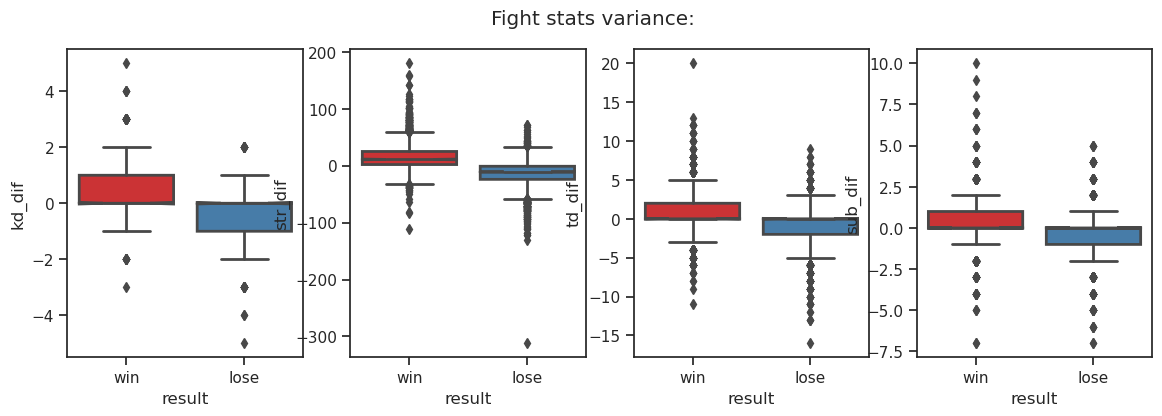

In [5]:
rows=1
cols=4
fig, axs = plt.subplots(rows,cols,figsize = (14,4))
fig.suptitle('Fight stats variance:')

sns.boxplot(ax=axs[0], x='result', y='kd_dif', data=df,notch=True, showcaps=True)
sns.boxplot(ax=axs[1], x='result', y='str_dif', data=df,notch=True, showcaps=True)
sns.boxplot(ax=axs[2], x='result', y='td_dif', data=df,notch=True, showcaps=True)
sns.boxplot(ax=axs[3], x='result', y='sub_dif', data=df,notch=True, showcaps=True)

fight stats contain significant varince > will be included as features

In [6]:
new_features = ['kd_dif','str_dif','td_dif','sub_dif']
for column in new_features:
    df[column] = (df[column] - np.mean(df[column]))/np.std(df[column])

df[new_features].head()    

,kd_dif,str_dif,td_dif,sub_dif
0,0.004210,2.592349,0.003196,-0.008752
1,1.350079,0.053021,0.003196,-0.008752
2,1.350079,0.089823,0.003196,-0.008752
3,0.004210,-0.940628,-0.389753,-0.008752
4,1.350079,-0.646214,0.003196,-0.008752


In [7]:
features = []
new_features = ['kd_dif','str_dif','td_dif','sub_dif']

for feature in new_features:
    features.append(feature)
    df[feature] = df[feature]

print('+ Features:')    
print(features)    

+ Features:
['kd_dif', 'str_dif', 'td_dif', 'sub_dif']


# <span style='color:green'> **[done]** </span> Feature Engineering = TakeDowns:
Exploring takedowns as feature using the following columns:
* <span style='color:blue'> **TD Avg.** </span> column
* <span style='color:blue'> **TD Acc.** </span> column
* <span style='color:blue'> **TD Def.** </span> column

In [8]:
tdf = (df[['result','kd_dif', 'str_dif', 'td_dif', 'sub_dif','fighter','opponent','f_td_avg','f_td_acc','f_td_def','o_td_avg','o_td_acc','o_td_def']]).copy()
tdf.head(3)

,result,kd_dif,str_dif,td_dif,sub_dif,fighter,opponent,f_td_avg,f_td_acc,f_td_def,o_td_avg,o_td_acc,o_td_def
0,win,0.004210,2.592349,0.003196,-0.008752,Max Holloway,Arnold Allen,0.28,0.53,0.84,1.12,0.50,0.76
1,win,1.350079,0.053021,0.003196,-0.008752,Edson Barboza,Billy Quarantillo,0.38,0.44,0.75,1.51,0.23,0.58
2,win,1.350079,0.089823,0.003196,-0.008752,Azamat Murzakanov,Dustin Jacoby,0.75,0.16,0.83,0.40,0.25,0.60


In [9]:
columns = ['td_avg','td_acc','td_def']
for column in columns:
    tdf[column + '_dif'] = tdf['f_' + column] - tdf['o_' + column]
    tdf[column + '_dif'] = (tdf[column + '_dif'] - np.mean(tdf[column + '_dif']))/np.std(tdf[column + '_dif'])
    
tdf = tdf[['result','kd_dif', 'str_dif', 'td_dif', 'sub_dif','td_avg_dif','td_acc_dif','td_def_dif']]   
tdf.head()

,result,kd_dif,str_dif,td_dif,sub_dif,td_avg_dif,td_acc_dif,td_def_dif
0,win,0.004210,2.592349,0.003196,-0.008752,-0.469071,0.098955,0.277653
1,win,1.350079,0.053021,0.003196,-0.008752,-0.631663,0.748713,0.588561
2,win,1.350079,0.089823,0.003196,-0.008752,0.198116,-0.334217,0.795832
3,lose,0.004210,-0.940628,-0.389753,-0.008752,-2.661255,-2.103002,-0.551433
4,win,1.350079,-0.646214,0.003196,-0.008752,0.074770,-0.622998,0.243108


<AxesSubplot:xlabel='result', ylabel='td_def_dif'>

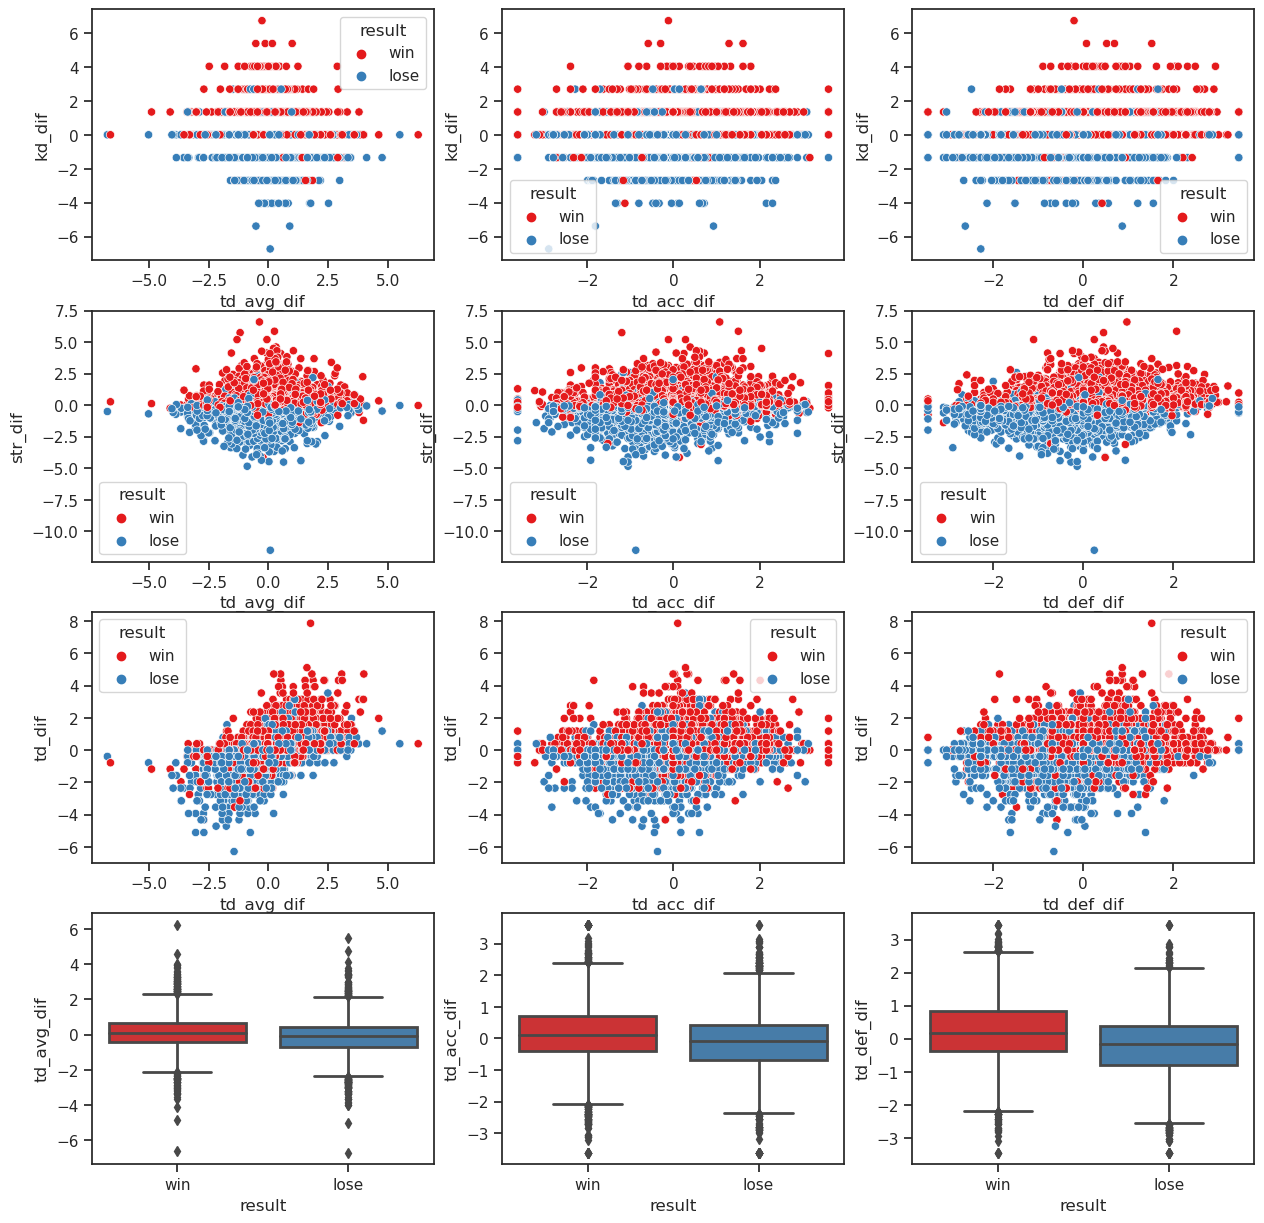

In [10]:
rows=4
cols=3
fig, axs = plt.subplots(rows,cols,figsize = (15,15))

sns.scatterplot(ax=axs[0,0], x='td_avg_dif', y='kd_dif', data=tdf, legend=True, hue='result')
sns.scatterplot(ax=axs[0,1], x='td_acc_dif', y='kd_dif', data=tdf, legend=True, hue='result')
sns.scatterplot(ax=axs[0,2], x='td_def_dif', y='kd_dif', data=tdf, legend=True, hue='result')

sns.scatterplot(ax=axs[1,0], x='td_avg_dif', y='str_dif', data=tdf, legend=True, hue='result')
sns.scatterplot(ax=axs[1,1], x='td_acc_dif', y='str_dif', data=tdf, legend=True, hue='result')
sns.scatterplot(ax=axs[1,2], x='td_def_dif', y='str_dif', data=tdf, legend=True, hue='result')

sns.scatterplot(ax=axs[2,0], x='td_avg_dif', y='td_dif', data=tdf, legend=True, hue='result')
sns.scatterplot(ax=axs[2,1], x='td_acc_dif', y='td_dif', data=tdf, legend=True, hue='result')
sns.scatterplot(ax=axs[2,2], x='td_def_dif', y='td_dif', data=tdf, legend=True, hue='result')

sns.boxplot(ax=axs[3,0], x='result', y='td_avg_dif', data=tdf)
sns.boxplot(ax=axs[3,1], x='result', y='td_acc_dif', data=tdf)
sns.boxplot(ax=axs[3,2], x='result', y='td_def_dif', data=tdf)

td_avg_dif & td_def_dif have some effect on td_dif & result

In [11]:
new_features = ['td_avg_dif','td_def_dif']

for feature in new_features:
    features.append(feature)
    df[feature] = tdf[feature]

print('+Features:')    
print(features)    

+Features:
['kd_dif', 'str_dif', 'td_dif', 'sub_dif', 'td_avg_dif', 'td_def_dif']


# <span style='color:green'> **[done]** </span> Feature Engineering = Submissions:
Exploring submissions as feature using the following columns:
* <span style='color:blue'> **Sub. Avg.** </span> column = average submission attempts

In [12]:
df.method.unique()

array(['U-DEC', 'KO/TKO', 'SUB', 'S-DEC', 'M-DEC', 'DQ'], dtype=object)

In [13]:
columns = ['result','kd_dif', 'str_dif', 'td_dif','sub_dif','method','fighter','opponent','f_sub_avg','o_sub_avg']
sub_df = (df[columns]).copy()
sub_df.head(3)

,result,kd_dif,str_dif,td_dif,sub_dif,method,fighter,opponent,f_sub_avg,o_sub_avg
0,win,0.004210,2.592349,0.003196,-0.008752,U-DEC,Max Holloway,Arnold Allen,0.3,0.3
1,win,1.350079,0.053021,0.003196,-0.008752,KO/TKO,Edson Barboza,Billy Quarantillo,0.1,1.2
2,win,1.350079,0.089823,0.003196,-0.008752,U-DEC,Azamat Murzakanov,Dustin Jacoby,0.0,0.0


In [14]:
column = 'sub_avg'
sub_df[column + '_dif'] = sub_df['f_' + column] - sub_df['o_' + column]
    
sub_df = sub_df[['result','method','kd_dif', 'str_dif', 'td_dif','sub_dif',column+'_dif']]   
sub_df.head()

,result,method,kd_dif,str_dif,td_dif,sub_dif,sub_avg_dif
0,win,U-DEC,0.004210,2.592349,0.003196,-0.008752,0.0
1,win,KO/TKO,1.350079,0.053021,0.003196,-0.008752,-1.1
2,win,U-DEC,1.350079,0.089823,0.003196,-0.008752,0.0
3,lose,KO/TKO,0.004210,-0.940628,-0.389753,-0.008752,0.0
4,win,U-DEC,1.350079,-0.646214,0.003196,-0.008752,0.5


<AxesSubplot:xlabel='sub_avg_dif', ylabel='sub_dif'>

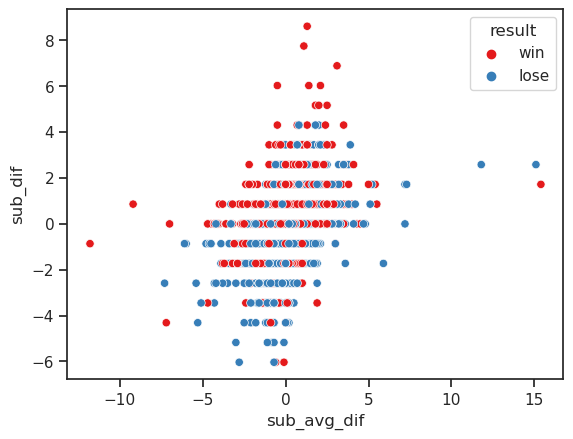

In [15]:
sns.scatterplot(x='sub_avg_dif', y='sub_dif', data=sub_df, hue='result')

it seems there is no impact of sub average on the fight outcome, 
i will check what is the case with fights that ended with submission:

,result,method,kd_dif,str_dif,td_dif,sub_dif,sub_avg_dif
0,lose,SUB,-1.341659,-0.683016,0.003196,-0.869692,1.4
1,win,SUB,0.004210,0.494644,0.396144,0.852188,1.0
2,win,SUB,0.004210,0.568247,0.396144,0.852188,1.4
3,lose,SUB,-1.341659,0.126625,-0.389753,-1.730633,-1.5
4,win,SUB,0.004210,0.089823,0.396144,0.852188,0.7


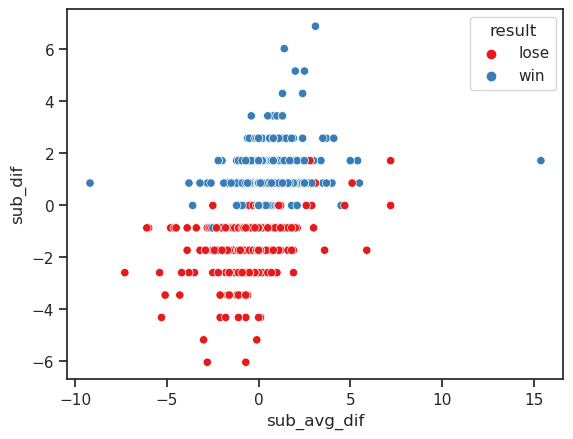

In [16]:
t = sub_df[sub_df.method == 'SUB'].reset_index(drop=True)
sns.scatterplot(x='sub_avg_dif', y='sub_dif', data=t, hue='result')
t.head(5)

after filtering only the fights that ended with submissions we see significant impact of "sub average", i will use it as a feature due to the fact that submission have big impact of how fighters fight(even though it might not end with sub)

In [17]:
feature = 'sub_avg_dif'
features.append(feature)
df[feature] = sub_df[feature]
    
print(features)   

['kd_dif', 'str_dif', 'td_dif', 'sub_dif', 'td_avg_dif', 'td_def_dif', 'sub_avg_dif']


# <span style='color:green'> **[done]** </span> Feature Engineering = Striking:

* <span style='color:blue'> **SLpM** </span> - Significant Strikes Landed per Minute
* <span style='color:blue'> **Str. Acc.** </span> - Significant Striking Accuracy
* <span style='color:blue'> **SApM** </span> - Significant Strikes Absorbed per Minute
* <span style='color:blue'> **Str. Def.** </span> - Significant Strike Defence (the % of opponents strikes that did not land)
* <span style='color:blue'> **Str. efc.** </span> - Sitriking effectivness = knockdown/strikes

In [18]:
df.head(3)

,result,fighter,opponent,weight_class,method,type,round,time,date,f_win_perc,o_win_perc,f_str_efc,o_str_efc,f_win_strk,o_win_strk,f_lose_strk,o_lose_strk,f_wins,f_losses,f_draws,f_height,f_weight,f_reach,f_stance,f_age,f_slpm,f_str_acc,f_sapm,f_str_def,f_td_avg,f_td_acc,f_td_def,f_sub_avg,f_last_match,o_wins,o_losses,o_draws,o_height,o_weight,o_reach,o_stance,o_age,o_slpm,o_str_acc,o_sapm,o_str_def,o_td_avg,o_td_acc,o_td_def,o_sub_avg,o_last_match,kd_dif,str_dif,td_dif,sub_dif,td_avg_dif,td_def_dif,sub_avg_dif
0,win,Max Holloway,Arnold Allen,Featherweight,U-DEC,Unanimous,5,5:00,2023-04-15,0.73,1.00,0.00269,0.00723,0,10,1,0,24,7,0,180.34,65.25,175.26,Orthodox,32.0,7.16,0.47,4.79,0.59,0.28,0.53,0.84,0.3,04-15-2023,19,2,0,172.72,65.25,177.80,Southpaw,29.0,3.34,0.40,2.86,0.61,1.12,0.50,0.76,0.3,04-15-2023,0.004210,2.592349,0.003196,-0.008752,-0.469071,0.277653,0.0
1,win,Edson Barboza,Billy Quarantillo,Featherweight,KO/TKO,Knee,1,2:37,2023-04-15,0.59,0.71,0.01128,0.00314,0,1,2,0,23,11,0,180.34,65.25,190.50,Orthodox,37.0,4.00,0.44,4.12,0.58,0.38,0.44,0.75,0.1,04-15-2023,17,5,0,177.80,65.25,177.80,Orthodox,35.0,7.86,0.58,5.79,0.40,1.51,0.23,0.58,1.2,04-15-2023,1.350079,0.053021,0.003196,-0.008752,-0.631663,0.588561,-1.1
2,win,Azamat Murzakanov,Dustin Jacoby,Light Heavyweight,U-DEC,Unanimous,3,5:00,2023-04-15,1.00,0.80,0.01266,0.00867,1,0,0,1,13,0,0,177.80,92.25,180.34,Southpaw,34.0,4.57,0.57,3.12,0.57,0.75,0.16,0.83,0.0,04-15-2023,18,7,1,190.50,92.25,193.04,Orthodox,35.0,5.44,0.47,4.03,0.58,0.40,0.25,0.60,0.0,04-15-2023,1.350079,0.089823,0.003196,-0.008752,0.198116,0.795832,0.0


In [19]:
str_df = (df[['result','fighter','opponent','method','f_slpm','o_slpm','f_str_acc','o_str_acc','f_sapm','o_sapm','f_str_def','o_str_def','f_str_efc','o_str_efc','str_dif']]).copy()
str_df.head()

,result,fighter,opponent,method,f_slpm,o_slpm,f_str_acc,o_str_acc,f_sapm,o_sapm,f_str_def,o_str_def,f_str_efc,o_str_efc,str_dif
0,win,Max Holloway,Arnold Allen,U-DEC,7.16,3.34,0.47,0.40,4.79,2.86,0.59,0.61,0.00269,0.00723,2.592349
1,win,Edson Barboza,Billy Quarantillo,KO/TKO,4.00,7.86,0.44,0.58,4.12,5.79,0.58,0.40,0.01128,0.00314,0.053021
2,win,Azamat Murzakanov,Dustin Jacoby,U-DEC,4.57,5.44,0.57,0.47,3.12,4.03,0.57,0.58,0.01266,0.00867,0.089823
3,lose,Tanner Boser,Ion Cutelaba,KO/TKO,4.17,4.63,0.51,0.43,2.47,3.29,0.60,0.48,0.00671,0.00505,-0.940628
4,win,Pedro Munhoz,Chris Gutierrez,U-DEC,5.30,4.75,0.43,0.58,5.90,2.76,0.57,0.64,0.00609,0.00901,-0.646214


In [20]:
columns = ['slpm','str_acc','sapm','str_def']
str_df['str_efc_dif'] = str_df['f_str_efc'] - str_df['o_str_efc']
for column in columns:
    str_df[column + '_dif'] = str_df['f_' + column] - str_df['o_' + column]
    str_df[column + '_dif'] = (str_df[column + '_dif'] - np.mean(str_df[column + '_dif']))/np.std(str_df[column + '_dif'])
    
str_df = str_df[['result','str_dif', columns[0] +'_dif',columns[1] +'_dif', columns[2] +'_dif', columns[3] +'_dif', 'str_efc_dif']]   
str_df.head()

,result,str_dif,slpm_dif,str_acc_dif,sapm_dif,str_def_dif,str_efc_dif
0,win,2.592349,2.382163,0.556290,1.222742,-0.194681,-0.00454
1,win,0.053021,-2.435135,-1.179316,-1.048464,1.546283,0.00814
2,win,0.089823,-0.559651,0.804233,-0.568988,-0.107633,0.00399
3,lose,-0.940628,-0.302477,0.638938,-0.512207,1.023994,0.00166
4,win,-0.646214,0.331048,-1.261964,1.986119,-0.629922,-0.00292


<AxesSubplot:xlabel='str_efc_dif', ylabel='str_dif'>

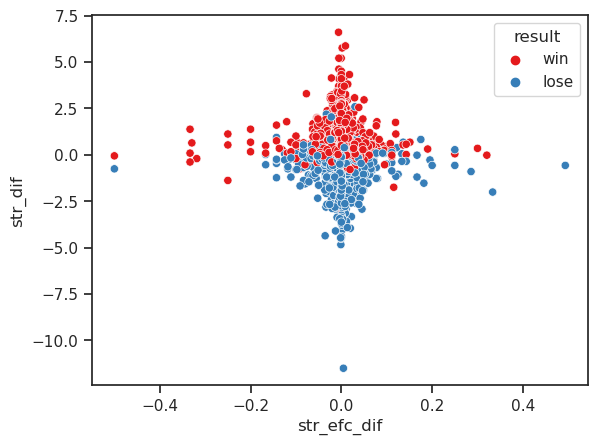

In [21]:
sns.scatterplot(data=str_df, x='str_efc_dif', y='str_dif', hue='result')

<AxesSubplot:xlabel='result', ylabel='str_dif'>

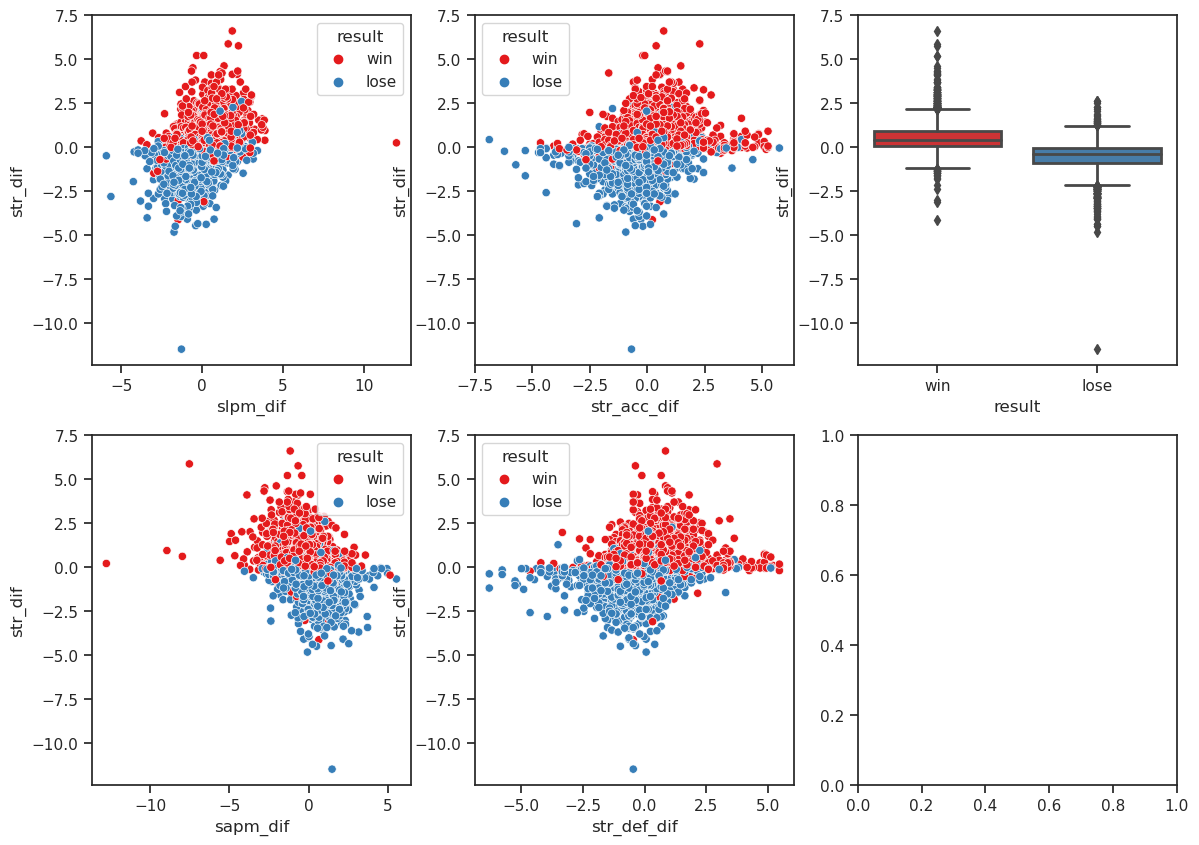

In [22]:
rows=2
cols=3
fig, axs = plt.subplots(rows,cols,figsize = (14,10))

sns.scatterplot(ax=axs[0,0], x='slpm_dif', y='str_dif', data=str_df, legend=True, hue='result')
sns.scatterplot(ax=axs[0,1], x='str_acc_dif', y='str_dif', data=str_df, legend=True, hue='result')
sns.scatterplot(ax=axs[1,0], x='sapm_dif', y='str_dif', data=str_df, legend=True, hue='result')
sns.scatterplot(ax=axs[1,1], x='str_def_dif', y='str_dif', data=str_df, legend=True, hue='result')
sns.boxplot(ax=axs[0,2], x='result', y='str_dif', data=str_df)

In [23]:
new_features = str_df.columns[1:]

for feature in new_features:
    features.append(feature)
    df[feature] = str_df[feature]

print('Features:')    
print(features)  

Features:
['kd_dif', 'str_dif', 'td_dif', 'sub_dif', 'td_avg_dif', 'td_def_dif', 'sub_avg_dif', 'str_dif', 'slpm_dif', 'str_acc_dif', 'sapm_dif', 'str_def_dif', 'str_efc_dif']


# <span style='color:green'> **[done]** </span> Feature Engineering = Height:

In [24]:
df.head(2)

,result,fighter,opponent,weight_class,method,type,round,time,date,f_win_perc,o_win_perc,f_str_efc,o_str_efc,f_win_strk,o_win_strk,f_lose_strk,o_lose_strk,f_wins,f_losses,f_draws,f_height,f_weight,f_reach,f_stance,f_age,f_slpm,f_str_acc,f_sapm,f_str_def,f_td_avg,f_td_acc,f_td_def,f_sub_avg,f_last_match,o_wins,o_losses,o_draws,o_height,o_weight,o_reach,o_stance,o_age,o_slpm,o_str_acc,o_sapm,o_str_def,o_td_avg,o_td_acc,o_td_def,o_sub_avg,o_last_match,kd_dif,str_dif,td_dif,sub_dif,td_avg_dif,td_def_dif,sub_avg_dif,slpm_dif,str_acc_dif,sapm_dif,str_def_dif,str_efc_dif
0,win,Max Holloway,Arnold Allen,Featherweight,U-DEC,Unanimous,5,5:00,2023-04-15,0.73,1.00,0.00269,0.00723,0,10,1,0,24,7,0,180.34,65.25,175.26,Orthodox,32.0,7.16,0.47,4.79,0.59,0.28,0.53,0.84,0.3,04-15-2023,19,2,0,172.72,65.25,177.8,Southpaw,29.0,3.34,0.40,2.86,0.61,1.12,0.50,0.76,0.3,04-15-2023,0.004210,2.592349,0.003196,-0.008752,-0.469071,0.277653,0.0,2.382163,0.556290,1.222742,-0.194681,-0.00454
1,win,Edson Barboza,Billy Quarantillo,Featherweight,KO/TKO,Knee,1,2:37,2023-04-15,0.59,0.71,0.01128,0.00314,0,1,2,0,23,11,0,180.34,65.25,190.50,Orthodox,37.0,4.00,0.44,4.12,0.58,0.38,0.44,0.75,0.1,04-15-2023,17,5,0,177.80,65.25,177.8,Orthodox,35.0,7.86,0.58,5.79,0.40,1.51,0.23,0.58,1.2,04-15-2023,1.350079,0.053021,0.003196,-0.008752,-0.631663,0.588561,-1.1,-2.435135,-1.179316,-1.048464,1.546283,0.00814


In [25]:
hdf = (df[['result','kd_dif','str_dif','td_dif','sub_dif','fighter','opponent','method','weight_class','f_height','o_height']]).copy()
hdf['height_dif'] = hdf['f_height'] - hdf['o_height']
hdf['height_dif'] = (hdf['height_dif'] - np.mean(hdf['height_dif']))/np.std(hdf['height_dif'])
hdf.head(3)

,result,kd_dif,str_dif,td_dif,sub_dif,fighter,opponent,method,weight_class,f_height,o_height,height_dif
0,win,0.004210,2.592349,0.003196,-0.008752,Max Holloway,Arnold Allen,U-DEC,Featherweight,180.34,172.72,1.168488
1,win,1.350079,0.053021,0.003196,-0.008752,Edson Barboza,Billy Quarantillo,KO/TKO,Featherweight,180.34,177.80,0.390328
2,win,1.350079,0.089823,0.003196,-0.008752,Azamat Murzakanov,Dustin Jacoby,U-DEC,Light Heavyweight,177.80,190.50,-1.944151


<AxesSubplot:xlabel='result', ylabel='height_dif'>

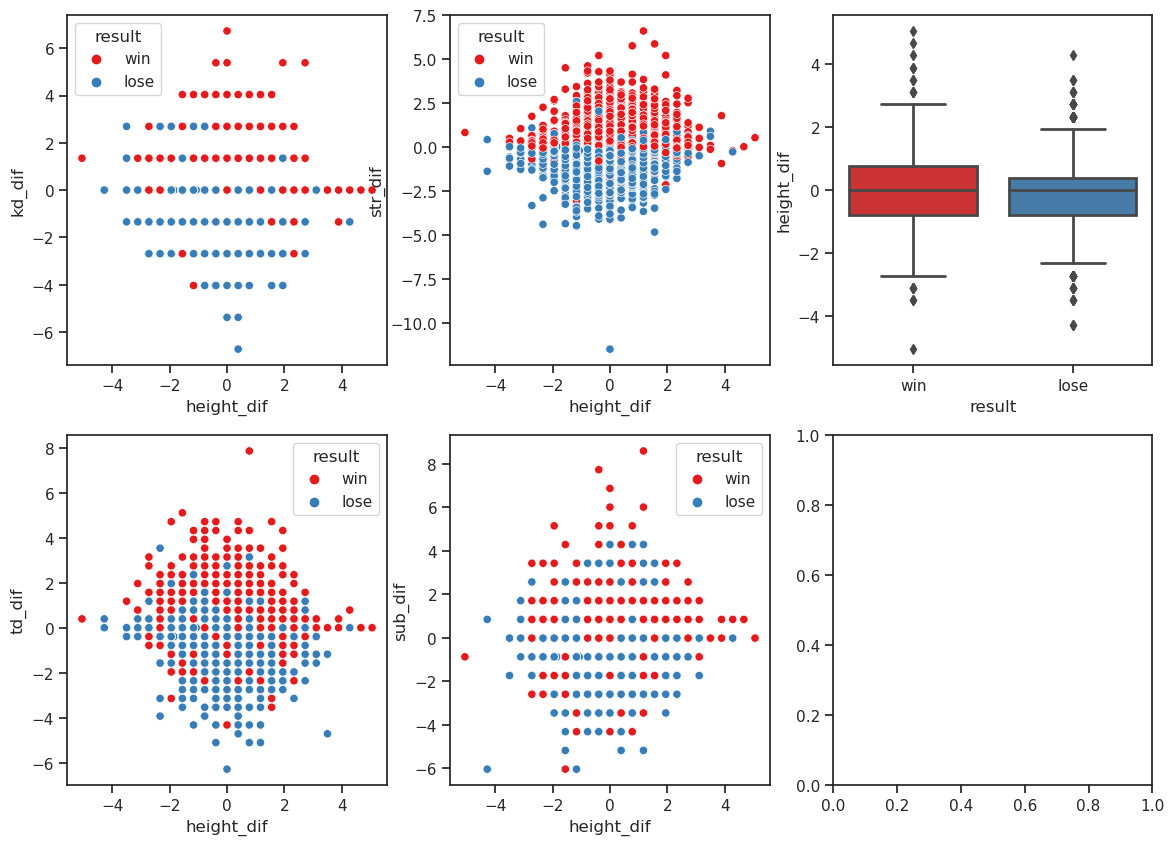

In [26]:
rows=2
cols=3
fig, axs = plt.subplots(rows,cols,figsize = (14,10))

sns.scatterplot(ax=axs[0,0], x='height_dif', y='kd_dif', data=hdf, legend=True, hue='result')
sns.scatterplot(ax=axs[0,1], x='height_dif', y='str_dif', data=hdf, legend=True, hue='result')
sns.scatterplot(ax=axs[1,0], x='height_dif', y='td_dif', data=hdf, legend=True, hue='result')
sns.scatterplot(ax=axs[1,1], x='height_dif', y='sub_dif', data=hdf, legend=True, hue='result')
sns.boxplot(ax=axs[0,2], x='result', y='height_dif', data=hdf)

height has no significant effect on fight outcome > will be dropped

# <span style='color:green'> **[done]** </span> Feature Engineering = Reach:

In [27]:
rdf = (df[['result','kd_dif','str_dif','td_dif','sub_dif','fighter','opponent','method','weight_class','f_reach','o_reach']]).copy()
rdf['reach_dif'] = rdf['f_reach'] - rdf['o_reach']
rdf['reach_dif'] = (rdf['reach_dif'] - np.mean(rdf['reach_dif']))/np.std(rdf['reach_dif'])
rdf.head(3)

,result,kd_dif,str_dif,td_dif,sub_dif,fighter,opponent,method,weight_class,f_reach,o_reach,reach_dif
0,win,0.004210,2.592349,0.003196,-0.008752,Max Holloway,Arnold Allen,U-DEC,Featherweight,175.26,177.80,-0.310784
1,win,1.350079,0.053021,0.003196,-0.008752,Edson Barboza,Billy Quarantillo,KO/TKO,Featherweight,190.50,177.80,1.529410
2,win,1.350079,0.089823,0.003196,-0.008752,Azamat Murzakanov,Dustin Jacoby,U-DEC,Light Heavyweight,180.34,193.04,-1.537579


<AxesSubplot:xlabel='result', ylabel='reach_dif'>

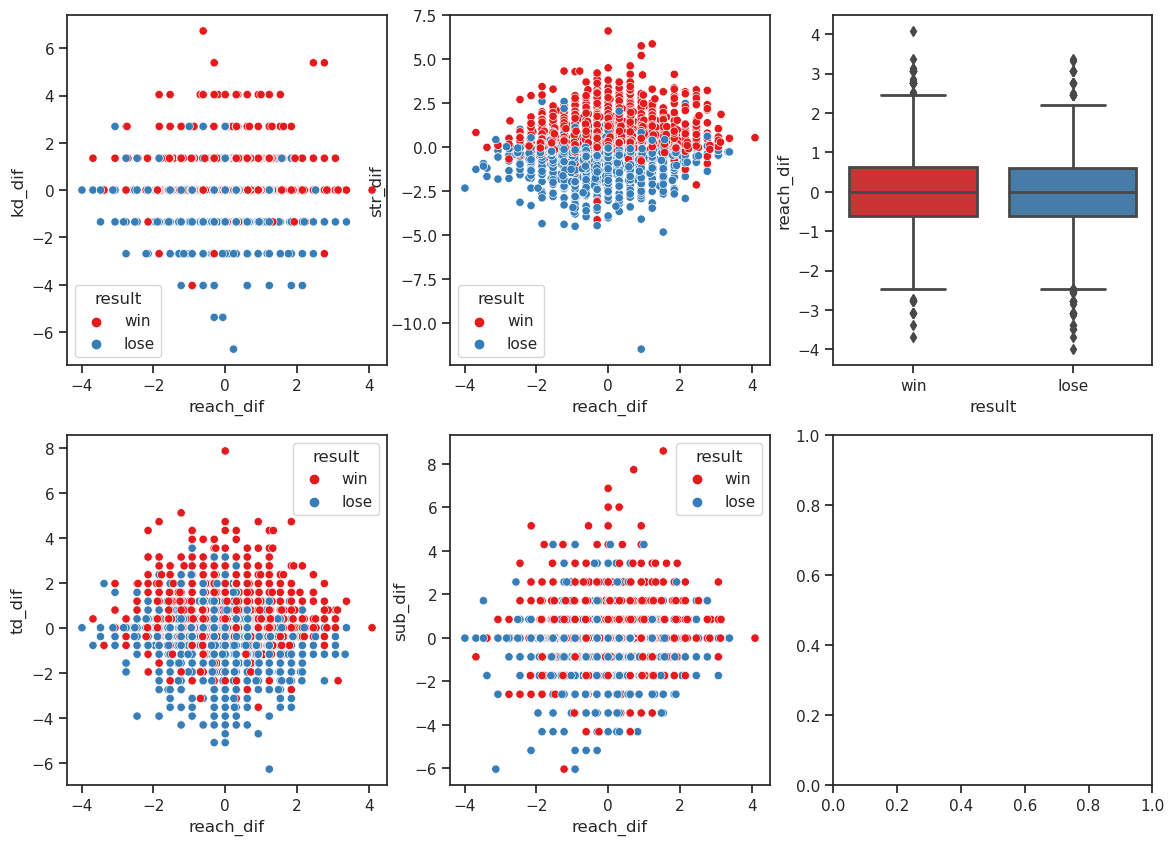

In [28]:
rows=2
cols=3
fig, axs = plt.subplots(rows,cols,figsize = (14,10))

sns.scatterplot(ax=axs[0,0], x='reach_dif', y='kd_dif', data=rdf, legend=True, hue='result')
sns.scatterplot(ax=axs[0,1], x='reach_dif', y='str_dif', data=rdf, legend=True, hue='result')
sns.scatterplot(ax=axs[1,0], x='reach_dif', y='td_dif', data=rdf, legend=True, hue='result')
sns.scatterplot(ax=axs[1,1], x='reach_dif', y='sub_dif', data=rdf, legend=True, hue='result')
sns.boxplot(ax=axs[0,2], x='result', y='reach_dif', data=rdf)

no significant effect on fight outcome > will be dropped

# <span style='color:green'> **[done]** </span> Feature Engineering = stance:

In [29]:
stance_df = (df[['result','kd_dif','str_dif','td_dif','sub_dif','fighter','opponent','f_stance','o_stance']]).copy()
stance_df['stance_combo'] = stance_df['f_stance'] + ':' + stance_df['o_stance']
stance_df.head(3)

,result,kd_dif,str_dif,td_dif,sub_dif,fighter,opponent,f_stance,o_stance,stance_combo
0,win,0.004210,2.592349,0.003196,-0.008752,Max Holloway,Arnold Allen,Orthodox,Southpaw,Orthodox:Southpaw
1,win,1.350079,0.053021,0.003196,-0.008752,Edson Barboza,Billy Quarantillo,Orthodox,Orthodox,Orthodox:Orthodox
2,win,1.350079,0.089823,0.003196,-0.008752,Azamat Murzakanov,Dustin Jacoby,Southpaw,Orthodox,Southpaw:Orthodox


<AxesSubplot:xlabel='f_stance', ylabel='td_dif'>

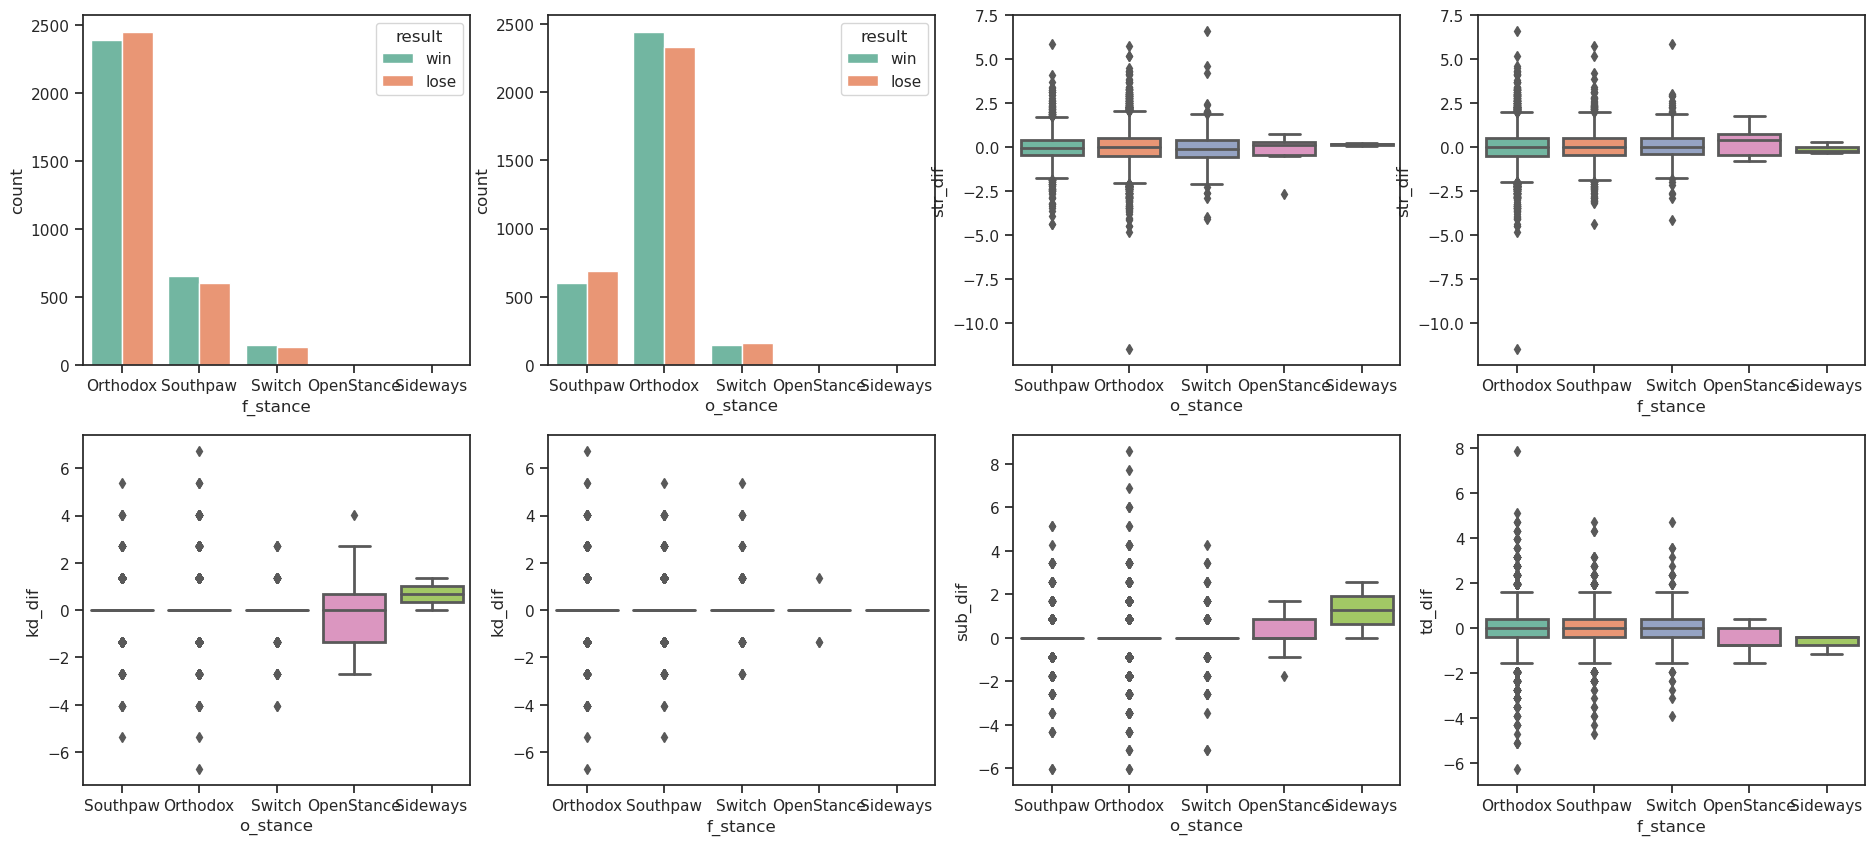

In [30]:
rows=2
cols=4
sns.set_palette("Set2")
fig, axs = plt.subplots(rows,cols,figsize = (23,10))

sns.countplot(ax=axs[0,0], x='f_stance', data=stance_df, hue='result')
sns.countplot(ax=axs[0,1], x='o_stance', data=stance_df, hue='result')
sns.boxplot(ax=axs[0,2], x='o_stance', y='str_dif', data=stance_df)
sns.boxplot(ax=axs[0,3], x='f_stance', y='str_dif', data=stance_df)
sns.boxplot(ax=axs[1,0], x='o_stance', y='kd_dif', data=stance_df)
sns.boxplot(ax=axs[1,1], x='f_stance', y='kd_dif', data=stance_df)
sns.boxplot(ax=axs[1,2], x='o_stance', y='sub_dif', data=stance_df)
sns.boxplot(ax=axs[1,3], x='f_stance', y='td_dif', data=stance_df)

In [31]:
stance_df['stance_win_ratio'] = None

for combo,i in zip(stance_df['stance_combo'],range(0,len(df))):
    stance_df.loc[i, 'stance_win_ratio'] = get_wins_ratio(combo=combo,data=stance_df)
    
stance_df.head(3)    

,result,kd_dif,str_dif,td_dif,sub_dif,fighter,opponent,f_stance,o_stance,stance_combo,stance_win_ratio
0,win,0.004210,2.592349,0.003196,-0.008752,Max Holloway,Arnold Allen,Orthodox,Southpaw,Orthodox:Southpaw,0.452256
1,win,1.350079,0.053021,0.003196,-0.008752,Edson Barboza,Billy Quarantillo,Orthodox,Orthodox,Orthodox:Orthodox,0.506423
2,win,1.350079,0.089823,0.003196,-0.008752,Azamat Murzakanov,Dustin Jacoby,Southpaw,Orthodox,Southpaw:Orthodox,0.530187


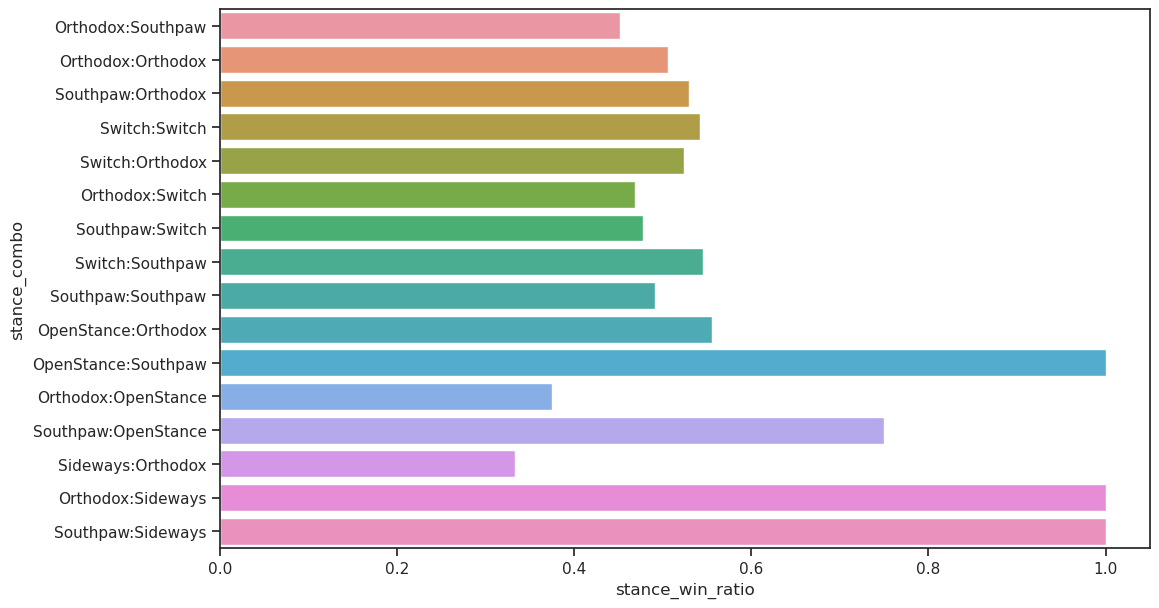

In [32]:
groupedvalues = stance_df.groupby('stance_combo').sum().reset_index()

plt.figure(figsize = (12,7))
ax = sns.barplot(data=stance_df, x="stance_win_ratio", y="stance_combo")

* some stances gives some edge ( >> 0.5) over its opponent stance,
* 1 or 0 stance_win_ratio is irrelevant (=only one time occured) so i will change it to 0.5 (=50:50 chance)

In [33]:
for i in range(0,len(stance_df)):
    
    if stance_df.loc[i,'stance_win_ratio'] == 1:
        stance_df.loc[i,'stance_win_ratio'] = 0.5
        
    if stance_df.loc[i,'stance_win_ratio'] == 0.0:
        stance_df.loc[i,'stance_win_ratio'] = 0.5 

# normalizing:
stance_df['stance_win_ratio'] = (stance_df['stance_win_ratio'] - np.mean(stance_df['stance_win_ratio']))/np.std(stance_df['stance_win_ratio'])        
stance_df.head(3)        

,result,kd_dif,str_dif,td_dif,sub_dif,fighter,opponent,f_stance,o_stance,stance_combo,stance_win_ratio
0,win,0.004210,2.592349,0.003196,-0.008752,Max Holloway,Arnold Allen,Orthodox,Southpaw,Orthodox:Southpaw,-1.880897
1,win,1.350079,0.053021,0.003196,-0.008752,Edson Barboza,Billy Quarantillo,Orthodox,Orthodox,Orthodox:Orthodox,0.232252
2,win,1.350079,0.089823,0.003196,-0.008752,Azamat Murzakanov,Dustin Jacoby,Southpaw,Orthodox,Southpaw:Orthodox,1.159339


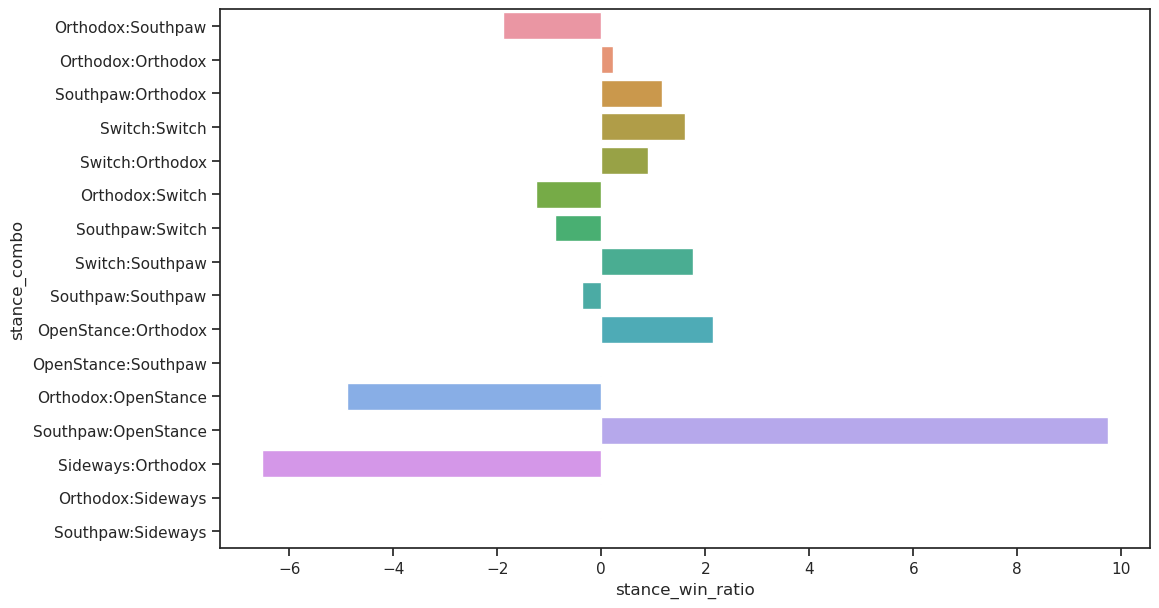

In [34]:
groupedvalues = stance_df.groupby('stance_combo').sum().reset_index()

plt.figure(figsize = (12,7))
ax = sns.barplot(data=stance_df, x="stance_win_ratio", y="stance_combo")

In [35]:
features.append('stance_win_ratio')
df['stance_win_ratio'] = stance_df['stance_win_ratio']
print(features)

['kd_dif', 'str_dif', 'td_dif', 'sub_dif', 'td_avg_dif', 'td_def_dif', 'sub_avg_dif', 'str_dif', 'slpm_dif', 'str_acc_dif', 'sapm_dif', 'str_def_dif', 'str_efc_dif', 'stance_win_ratio']


# <span style='color:green'> **[done]** </span> Feature Engineering = Win/Lose streak:

In [36]:
win_df = (df[['result','fighter','opponent','f_win_perc','o_win_perc','f_win_strk','o_win_strk','f_lose_strk','o_lose_strk']]).copy()
win_df.head(3)

,result,fighter,opponent,f_win_perc,o_win_perc,f_win_strk,o_win_strk,f_lose_strk,o_lose_strk
0,win,Max Holloway,Arnold Allen,0.73,1.00,0,10,1,0
1,win,Edson Barboza,Billy Quarantillo,0.59,0.71,0,1,2,0
2,win,Azamat Murzakanov,Dustin Jacoby,1.00,0.80,1,0,0,1


In [37]:
columns = ['win_perc','win_strk','lose_strk']

for column in columns:
    win_df[column + '_dif'] = win_df['f_' + column] - win_df['o_' + column]
    win_df[column + '_dif'] = (win_df[column + '_dif'] - np.mean(win_df[column + '_dif']))/np.std(win_df[column + '_dif'])
    
win_df = win_df[['result', columns[0] +'_dif',columns[1] +'_dif', columns[2] +'_dif']]   
win_df.head()

,result,win_perc_dif,win_strk_dif,lose_strk_dif
0,win,-0.666814,-5.559232,1.001957
1,win,-0.295587,-0.547693,2.022101
2,win,0.496362,0.565982,-1.038333
3,lose,0.125135,0.009144,-2.058478
4,win,-1.161782,-3.331881,2.022101


<AxesSubplot:xlabel='result', ylabel='win_perc_dif'>

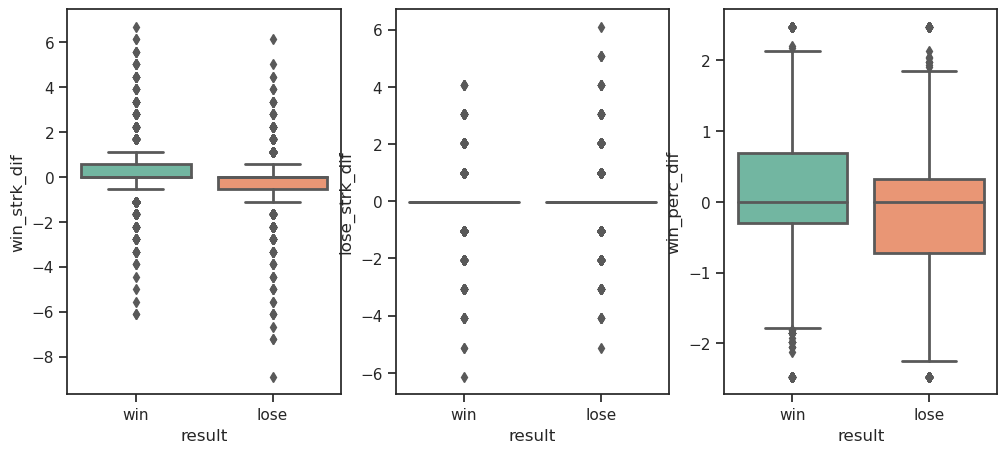

In [38]:
rows=1
cols=3
sns.set_palette("Set2")
fig, axs = plt.subplots(rows,cols,figsize = (12,5))

sns.boxplot(ax=axs[0], x='result', y='win_strk_dif',data=win_df)
sns.boxplot(ax=axs[1], x='result', y='lose_strk_dif',data=win_df)
sns.boxplot(ax=axs[2], x='result', y='win_perc_dif',data=win_df)

we can see very significant variance > might be the strongest predictor for fight's winner > will be included as features

In [39]:
new_features = win_df.columns[1:]
for feature in new_features:
    features.append(feature)
    df[feature] = win_df[feature]
    
print(features)    

['kd_dif', 'str_dif', 'td_dif', 'sub_dif', 'td_avg_dif', 'td_def_dif', 'sub_avg_dif', 'str_dif', 'slpm_dif', 'str_acc_dif', 'sapm_dif', 'str_def_dif', 'str_efc_dif', 'stance_win_ratio', 'win_perc_dif', 'win_strk_dif', 'lose_strk_dif']


# <span style='color:green'> **[done]** </span> saving Features data file:

In [40]:
columns = ['result','fighter','opponent','date','weight_class','method','type']
for feature in features:
    columns.append(feature)

final_df = df[columns]
final_df = final_df.dropna()
final_df.head(3)

,result,fighter,opponent,date,weight_class,method,type,kd_dif,str_dif,td_dif,sub_dif,td_avg_dif,td_def_dif,sub_avg_dif,str_dif,slpm_dif,str_acc_dif,sapm_dif,str_def_dif,str_efc_dif,stance_win_ratio,win_perc_dif,win_strk_dif,lose_strk_dif
0,win,Max Holloway,Arnold Allen,2023-04-15,Featherweight,U-DEC,Unanimous,0.004210,2.592349,0.003196,-0.008752,-0.469071,0.277653,0.0,2.592349,2.382163,0.556290,1.222742,-0.194681,-0.00454,-1.880897,-0.666814,-5.559232,1.001957
1,win,Edson Barboza,Billy Quarantillo,2023-04-15,Featherweight,KO/TKO,Knee,1.350079,0.053021,0.003196,-0.008752,-0.631663,0.588561,-1.1,0.053021,-2.435135,-1.179316,-1.048464,1.546283,0.00814,0.232252,-0.295587,-0.547693,2.022101
2,win,Azamat Murzakanov,Dustin Jacoby,2023-04-15,Light Heavyweight,U-DEC,Unanimous,1.350079,0.089823,0.003196,-0.008752,0.198116,0.795832,0.0,0.089823,-0.559651,0.804233,-0.568988,-0.107633,0.00399,1.159339,0.496362,0.565982,-1.038333


In [41]:
try:
    final_df.to_csv('../data/data_features.csv', index=0)
    print('../data/data_features.csv saved.')
except:    
    print('error occurs saving ../data/data_features.csv - might be file in use.')

../data/data_features.csv saved.
